# Data preparation

## Import base

In [1]:
import pandas as pd

In [2]:
credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [6]:
credits.dtypes
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [7]:
movies.shape

(4803, 20)

In [8]:
credits.shape

(4803, 4)

In [9]:
# Let's just transform the release date to a datetime type
movies['release_date'] = pd.to_datetime(movies['release_date'])

## Merge credits and movie

In [10]:
data = credits.merge(movies, left_on='movie_id', right_on='id')

In [11]:
data

,movie_id,title_x,cast,crew,budget,genres,homepage,id,keywords,original_language,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,...,"[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,...,[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...",0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallm

In [12]:
data.drop(columns='id', inplace=True)

In [13]:
data.set_index('movie_id', inplace=True)

In [14]:
data.head()

,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


## Removing missing values

In [15]:
data.isna().sum()

title_x                    0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_y                    0
vote_average               0
vote_count                 0
dtype: int64

We see that almost all homepages are missing, and as they are not particularly useful, removing completely the column should do. As for the release date and the runtime, we should be able to substitute a reasonable value. The most difficult is going to be working with the missing taglines, but we might end up not using them. 

In [16]:
# Let's take care of the missing release date
data.drop(index=data[data['release_date'].isna()].index, inplace=True)
# This particular movies was too recently released, and everything is missing so we drop it
# It seems that we didn't take into account all the empty lists and null values 

In [17]:
chimameti = data[data['runtime'].isna()].index[0]
frank_sinatra = data[data['runtime'].isna()].index[1]
data.loc[chimameti, 'runtime'] = 113.0
data.loc[frank_sinatra, 'runtime'] = 81.0

We are going to differentiate in addition of the existing data types lists and strings. It's going to be important as the list have subattributes that can be extracted later, but also because the missing value manifests by an empty list which isn't considered NaN by pandas.

In [18]:
data.dtypes

title_x                         object
cast                            object
crew                            object
budget                           int64
genres                          object
homepage                        object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
title_y                         object
vote_average                   float64
vote_count                       int64
dtype: object

In [19]:
# Let's split the database by column type so that we can search for missing values properly
(data.select_dtypes('number') == 0).sum()

budget          1036
popularity         0
revenue         1426
runtime           34
vote_average      62
vote_count        61
dtype: int64

In [20]:
# Here we split the columns between strings and json 
str_cols, json_cols = [], []
for column in data.select_dtypes('object'):
    if data[column].iloc[0][0] == '[':
        json_cols.append(column)
    else :
        str_cols.append(column)

In [21]:
for column in data[json_cols]:
    data[column] = data[column].map(eval)

In [22]:
(data[json_cols].applymap(len) == 0).sum()

cast                     42
crew                     27
genres                   27
keywords                411
production_companies    350
production_countries    173
spoken_languages         85
dtype: int64

In [23]:
data['cast'][285]

[{'cast_id': 4,
  'character': 'Captain Jack Sparrow',
  'credit_id': '52fe4232c3a36847f800b50d',
  'gender': 2,
  'id': 85,
  'name': 'Johnny Depp',
  'order': 0},
 {'cast_id': 5,
  'character': 'Will Turner',
  'credit_id': '52fe4232c3a36847f800b511',
  'gender': 2,
  'id': 114,
  'name': 'Orlando Bloom',
  'order': 1},
 {'cast_id': 6,
  'character': 'Elizabeth Swann',
  'credit_id': '52fe4232c3a36847f800b515',
  'gender': 1,
  'id': 116,
  'name': 'Keira Knightley',
  'order': 2},
 {'cast_id': 12,
  'character': 'William "Bootstrap Bill" Turner',
  'credit_id': '52fe4232c3a36847f800b52d',
  'gender': 2,
  'id': 1640,
  'name': 'Stellan Skarsgård',
  'order': 3},
 {'cast_id': 10,
  'character': 'Captain Sao Feng',
  'credit_id': '52fe4232c3a36847f800b525',
  'gender': 2,
  'id': 1619,
  'name': 'Chow Yun-fat',
  'order': 4},
 {'cast_id': 9,
  'character': 'Captain Davy Jones',
  'credit_id': '52fe4232c3a36847f800b521',
  'gender': 2,
  'id': 2440,
  'name': 'Bill Nighy',
  'order': 5

In [24]:
data[str_cols].isna().sum()

title_x                 0
homepage             3090
original_language       0
original_title          0
overview                3
status                  0
tagline               843
title_y                 0
dtype: int64

In [25]:
chimameti_desc = 'A biopic of the rise of father Jorge Mario Bergoglio SJ from a teacher in a Jesuit High School in Argentina to archbishop and cardinal of Buenos Aires to Pope of the Roman Catholic Church. The story touches on his relation with his fellow Jesuits in Argentina and Europe, to his relation with laureate writer Jorge Luis Borges, Argentine dictator Jorge Rafael Videla, and archbishops Laghi (nuncio to Argentina) and Quarracino (cardinal of Buenos Aires), up to the moment where he is elected Pope in 2013'
frank_sinatra_desc = 'The life of Frank Sinatra, as an actor and singer and the steps along the way that led him to become such an icon.'
food_chains_desc = 'There is so much interest in food these days yet there is almost no interest in the hands that pick that food. In the US, farm labor has always been one of the most difficult and poorly paid jobs and has relied on some of the nation\'s most vulnerable people. While the legal restrictions which kept people bound to farms, like slavery, have been abolished, exploitation still exists, ranging from wage theft to modern-day slavery. These days, this exploitation is perpetuated by the corporations at the top of the food chain: supermarkets. Their buying power has kept wages pitifully low and has created a scenario where desperately poor people are willing to put up with anything to keep their jobs.'

In [26]:
data[data['overview'].isna()]

,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
movie_id,,,,,,,,,,,,,,,,,,,,,
370980,Chiamatemi Francesco - Il Papa della gente,"[{'cast_id': 5, 'character': 'Jorge Mario Berg...","[{'credit_id': '5660019ac3a36875f100252b', 'de...",15000000,"[{'id': 18, 'name': 'Drama'}]",NaN,"[{'id': 717, 'name': 'pope'}, {'id': 5565, 'na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,...,"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2015-12-03,0,113.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
459488,"To Be Frank, Sinatra at 100","[{'cast_id': 0, 'character': 'Narrator', 'cred...","[{'credit_id': '592b25e4c3a368783e065a2f', 'de...",2,"[{'id': 99, 'name': 'Documentary'}]",NaN,"[{'id': 6027, 'name': 'music'}, {'id': 225822,...",en,"To Be Frank, Sinatra at 100",NaN,...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2015-12-12,0,81.0,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0
292539,Food Chains,[],"[{'credit_id': '5470c3b1c3a368085e000abd', 'de...",913000,"[{'id': 99, 'name': 'Documentary'}]",NaN,[],de,Food Chains,NaN,...,[],2014-04-26,0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Food Chains,7.4,8


In [27]:
# Let's fill in manually the missing overviews
data.loc[chimameti, 'overview'] = chimameti_desc
data.loc[frank_sinatra, 'overview'] = frank_sinatra
data.loc[data['overview'].isna(), 'overview'] = food_chains_desc

In [28]:
data.drop(columns='homepage', inplace=True)

We delete the lines where cast or crew is missing because it would be much more work to recover these information and only a few are missing. 

In [29]:
data.drop(index=data[data['crew'].map(len) == 0].index, inplace=True)
data.drop(index=data[data['cast'].map(len) == 0].index, inplace=True)

Now we need to consider all the 'list' missing values. Those are more difficult to handle because they involve ids and conventions from the database. It's relatively easy to scrap imdb but less to match the info we can get there with the ones we already have. We will leave this part for when we have a specific id of our need in terms of missing values. 

# Initial analysis

In [34]:
import matplotlib.pyplot as plt

In [39]:
import seaborn as sns

In [30]:
data.corr()

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.502944,0.729985,0.266367,0.084750,0.591561
popularity,0.502944,1.000000,0.643566,0.220842,0.278880,0.777308
revenue,0.729985,0.643566,1.000000,0.250886,0.200148,0.780861
runtime,0.266367,0.220842,0.250886,1.000000,0.363044,0.271530
vote_average,0.084750,0.278880,0.200148,0.363044,1.000000,0.322849
vote_count,0.591561,0.777308,0.780861,0.271530,0.322849,1.000000


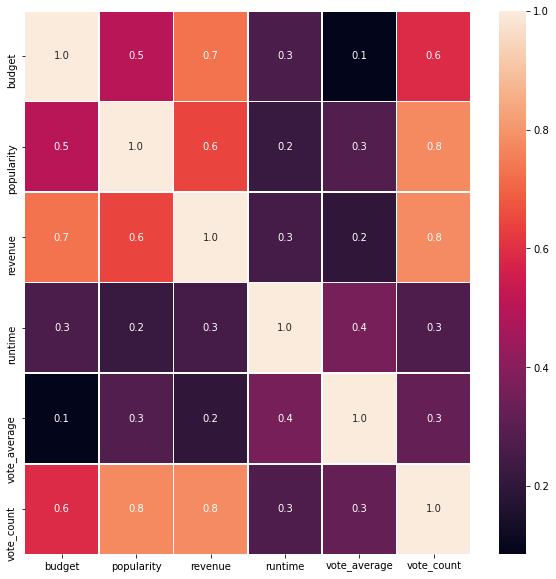

In [40]:
## Correlation map visualisation
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(), annot = True, linewidths=.5, fmt = '.1f', ax = ax)
plt.show()


## Recommending by rating
TODO : paragraph about imdb ratings

We will start with a simple recommendation system which simply recommends the best movies in the database.

In [ ]:
# Let's choose the minimum amount of ratings for us to consider the movie
# Here we only take into account movies that have more votes than 80% of the list
min_votes = data['vote_count'].quantile(0.8)
min_votes

In [ ]:
v = data['vote_count']
m = min_votes
R = data['vote_average']
C = data['vote_average'].mean()

In [ ]:
data['weighted_rating'] = (v / (v + m) * R) + (m / (v+m) * C)
data

In [ ]:
# The best movies of all time ...
data.sort_values('weighted_rating', ascending=False).head(10)

In [ ]:
# Which is not the same as if we sort by popularity
data.sort_values('popularity', ascending=False).head(10)

A rating and recommendation system based on votes or popularity alone is not very effective nor very interesting, because it's not personnalised at all. So let's see what makes movies close to each other.

## Recommendation based on genre and quality 

We can make another simple recommendation system which is more personnalised. Given a movie, this recommendation system will score all other movies in terms of genre proximity and rating. It will give us back the movies with the best score ! This system is very simple but can be extended quite easily to the keyword category and make an overall not so simple recommendation system.